In [ ]:

# Day 8 — Movie Recommendation System (MovieLens 20M)


# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# ML / evaluation utilities
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")


# Visualization style

plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

In [ ]:

# Load preprocessed datasets (produced by scripts/preprocess.py)

proc_dir = Path("data/processed")

print("[INFO] Loading preprocessed data from:", proc_dir)

train = pd.read_csv(proc_dir / "train.csv")
test = pd.read_csv(proc_dir / "test.csv")
movies = pd.read_csv(proc_dir / "movies_clean.csv")
genome_tags = pd.read_csv(proc_dir / "genome_tags.csv")


# Quick sanity check

print(f"[INFO] Train set shape: {train.shape}")
print(f"[INFO] Test set shape:  {test.shape}")
print(f"[INFO] Movies catalog:  {len(movies)} entries")

print("\n[INFO] Train columns:")
print(train.columns.tolist())

print("\n[INFO] Sample rows from training data:")
display(train.head())


[INFO] Loading preprocessed data from: data\processed
[INFO] Train set shape: (13344487, 23)
[INFO] Test set shape:  (3336122, 21)
[INFO] Movies catalog:  27278 entries

[INFO] Train columns:
['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'user_tags', 'genome_mean', 'genome_max', 'genome_std', 'movie_avg_rating', 'movie_n_ratings', 'movie_bayesian_avg', 'user_avg_rating', 'user_rating_std', 'user_n_ratings', 'rating_year', 'rating_month', 'rating_dow', 'is_weekend', 'rating_z', 'user_idx', 'movie_idx']

[INFO] Sample rows from training data:


,userId,movieId,rating,timestamp,title,genres,user_tags,genome_mean,genome_max,genome_std,...,user_avg_rating,user_rating_std,user_n_ratings,rating_year,rating_month,rating_dow,is_weekend,rating_z,user_idx,movie_idx
0,28507,1176,4.0,1995-01-09 11:46:44,"Double Life of Veronique, The (Double Vie de V...",Drama|Fantasy|Romance,"2.5, criterion, dvd, enigmatic, erlend's dvds,...",0.134188,0.98700,0.188213,...,3.784483,0.586901,116,1995,1,0,0,0.367212,10242,1151
1,99851,45,4.0,1996-01-29 00:00:00,To Die For (1995),Comedy|Drama|Thriller,"100 essential female performances, best perfor...",0.113553,0.98800,0.148917,...,4.160920,0.729344,87,1996,1,0,0,-0.220636,35881,44
2,99851,58,5.0,1996-01-29 00:00:00,"Postman, The (Postino, Il) (1994)",Comedy|Drama|Romance,"beautiful scenery, beautifully filmed, boring,...",0.128207,0.96200,0.171086,...,4.160920,0.729344,87,1996,1,0,0,1.150458,35881,57
3,85252,17,5.0,1996-01-29 00:00:00,Sense and Sensibility (1995),Drama|Romance,"18th century, 19th century, adapted from:book,...",0.112152,0.98000,0.165524,...,3.742424,0.883761,198,1996,1,0,0,1.422981,30571,16
4,85252,12,1.0,1996-01-29 00:00:00,Dracula: Dead and Loving It (1995),Comedy|Horror,"bd-r, gothic, leslie nielsen, mel brooks, spoo...",0.077325,0.99675,0.110264,...,3.742424,0.883761,198,1996,1,0,0,-3.103128,30571,11


### Data Audit — Preprocessed MovieLens Dataset

#### Overview
This cell confirms successful loading of the **preprocessed MovieLens dataset** used for training and evaluating a hybrid recommender system. It provides dataset dimensions, schema details, and a sample of enriched rows that combine raw ratings with engineered features.

---

#### Dataset Shapes
- **Train set:** 13,344,487 rows × 23 columns  
- **Test set:** 3,336,122 rows × 21 columns  
- **Movies catalog:** 27,278 unique entries  

This scale reflects a large but manageable subset of MovieLens 20M, split temporally to avoid leakage and ensure realistic evaluation.

---

#### Feature Schema

##### Identifiers
- `userId`, `movieId`: Original IDs for joins and reporting.  
- `user_idx`, `movie_idx`: Encoded indices for matrix operations (CF, SVD).

##### Target & Time
- `rating`: Explicit rating (0.5–5.0).  
- `timestamp`: Converted to datetime for temporal analysis.  
- `rating_year`, `rating_month`, `rating_dow`, `is_weekend`: Derived temporal features capturing seasonality and behavior patterns.

##### Movie Metadata
- `title`, `genres`: Human-readable labels and multi-genre strings.  
- `user_tags`: Aggregated tags applied by users.

##### Genome Features
- `genome_mean`, `genome_max`, `genome_std`: Summary statistics of tag relevance scores, describing semantic richness and specificity.

##### Movie Aggregates
- `movie_avg_rating`: Average rating for the movie.  
- `movie_n_ratings`: Popularity measure.  
- `movie_bayesian_avg`: Credibility-weighted score to stabilize sparse ratings.

##### User Aggregates
- `user_avg_rating`: Personal bias baseline.  
- `user_rating_std`: Variability in ratings (consistency of taste).  
- `user_n_ratings`: Activity level.

##### Normalization
- `rating_z`: Z-score normalized rating relative to user’s average and variance.

---

**Observations:**
- Users show consistent rating behavior (e.g., user 85252 with 198 ratings, std ~0.88).  
- Genome features capture semantic density (high `genome_max` ~0.99 indicates strong tag relevance).  
- `rating_z` highlights deviations from user baseline (positive for above-average ratings, negative for harsh ratings).  
- Multi-genre movies support nuanced similarity measures.

---

#### Implications for Modeling
- **Collaborative Filtering:** Use `user_idx` and `movie_idx` for efficient sparse matrix operations; similarity computed on `rating_z` reduces bias.  
- **Matrix Factorization (SVD):** Latent factors trained on normalized ratings; explained variance guides component choice.  
- **Content-Based Filtering:** Genome statistics and genres provide semantic similarity; tags enrich interpretability.  
- **Hybrid Ensemble:** Weighted combination leverages CF for personalization, SVD for latent structure, and content-based for cold-start resilience.

In [7]:
print(train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13344487 entries, 0 to 13344486
Data columns (total 23 columns):
 #   Column              Dtype  
---  ------              -----  
 0   userId              int64  
 1   movieId             int64  
 2   rating              float64
 3   timestamp           object 
 4   title               object 
 5   genres              object 
 6   user_tags           object 
 7   genome_mean         float64
 8   genome_max          float64
 9   genome_std          float64
 10  movie_avg_rating    float64
 11  movie_n_ratings     int64  
 12  movie_bayesian_avg  float64
 13  user_avg_rating     float64
 14  user_rating_std     float64
 15  user_n_ratings      int64  
 16  rating_year         int64  
 17  rating_month        int64  
 18  rating_dow          int64  
 19  is_weekend          int64  
 20  rating_z            float64
 21  user_idx            int64  
 22  movie_idx           int64  
dtypes: float64(9), int64(10), object(4)
memory usage: 2.3+ 

### DataFrame Structure — Preprocessed MovieLens Training Set

#### Overview
This cell output provides the **structural summary** of the preprocessed training dataset used in the hybrid movie recommendation pipeline. It shows the number of rows, columns, data types, and memory footprint, confirming the scale and richness of the dataset.

---

#### Dataset Dimensions
- **Entries (rows):** 13,344,487  
- **Columns (features):** 23  
- **Index:** RangeIndex from 0 to 13,344,486  
- **Memory usage:** ~2.3 GB  

This scale reflects a large, production-grade dataset sampled from MovieLens 20M, suitable for training collaborative filtering, matrix factorization, and content-based models.

---

#### Column Breakdown by Data Type

##### Integer (`int64`) — 10 columns
- **Identifiers:** `userId`, `movieId`, `user_idx`, `movie_idx`  
- **Counts:** `movie_n_ratings`, `user_n_ratings`  
- **Temporal features:** `rating_year`, `rating_month`, `rating_dow`, `is_weekend`  

##### Float (`float64`) — 9 columns
- **Target:** `rating`  
- **Genome statistics:** `genome_mean`, `genome_max`, `genome_std`  
- **Movie aggregates:** `movie_avg_rating`, `movie_bayesian_avg`  
- **User aggregates:** `user_avg_rating`, `user_rating_std`  
- **Normalization:** `rating_z`  

##### Object (`object`) — 4 columns
- **Metadata:** `timestamp`, `title`, `genres`, `user_tags`  

---

#### Key Observations
- **Scale:** With 13M+ rows, the dataset is large enough to capture diverse user behaviors while still manageable in memory (~2.3 GB).  
- **Balance of features:** Numeric columns dominate (19/23), enabling efficient matrix operations and statistical modeling.  
- **Rich metadata:** Textual fields (`title`, `genres`, `user_tags`) support explainability and content-based similarity.  
- **Temporal granularity:** Year, month, day-of-week, and weekend flags allow time-aware recommendation strategies.  
- **Normalization:** `rating_z` reduces user bias, making collaborative filtering and SVD more robust.  

---

#### Implications for Modeling
- **Collaborative Filtering:** Integer indices (`user_idx`, `movie_idx`) enable efficient sparse matrix construction.  
- **Matrix Factorization (SVD):** Float features provide stable input for latent factor decomposition.  
- **Content-Based Filtering:** Object fields (`genres`, `user_tags`) enrich semantic similarity.  
- **Hybrid Ensemble:** Combination of numeric aggregates, temporal features, and metadata supports balanced recommendations.  

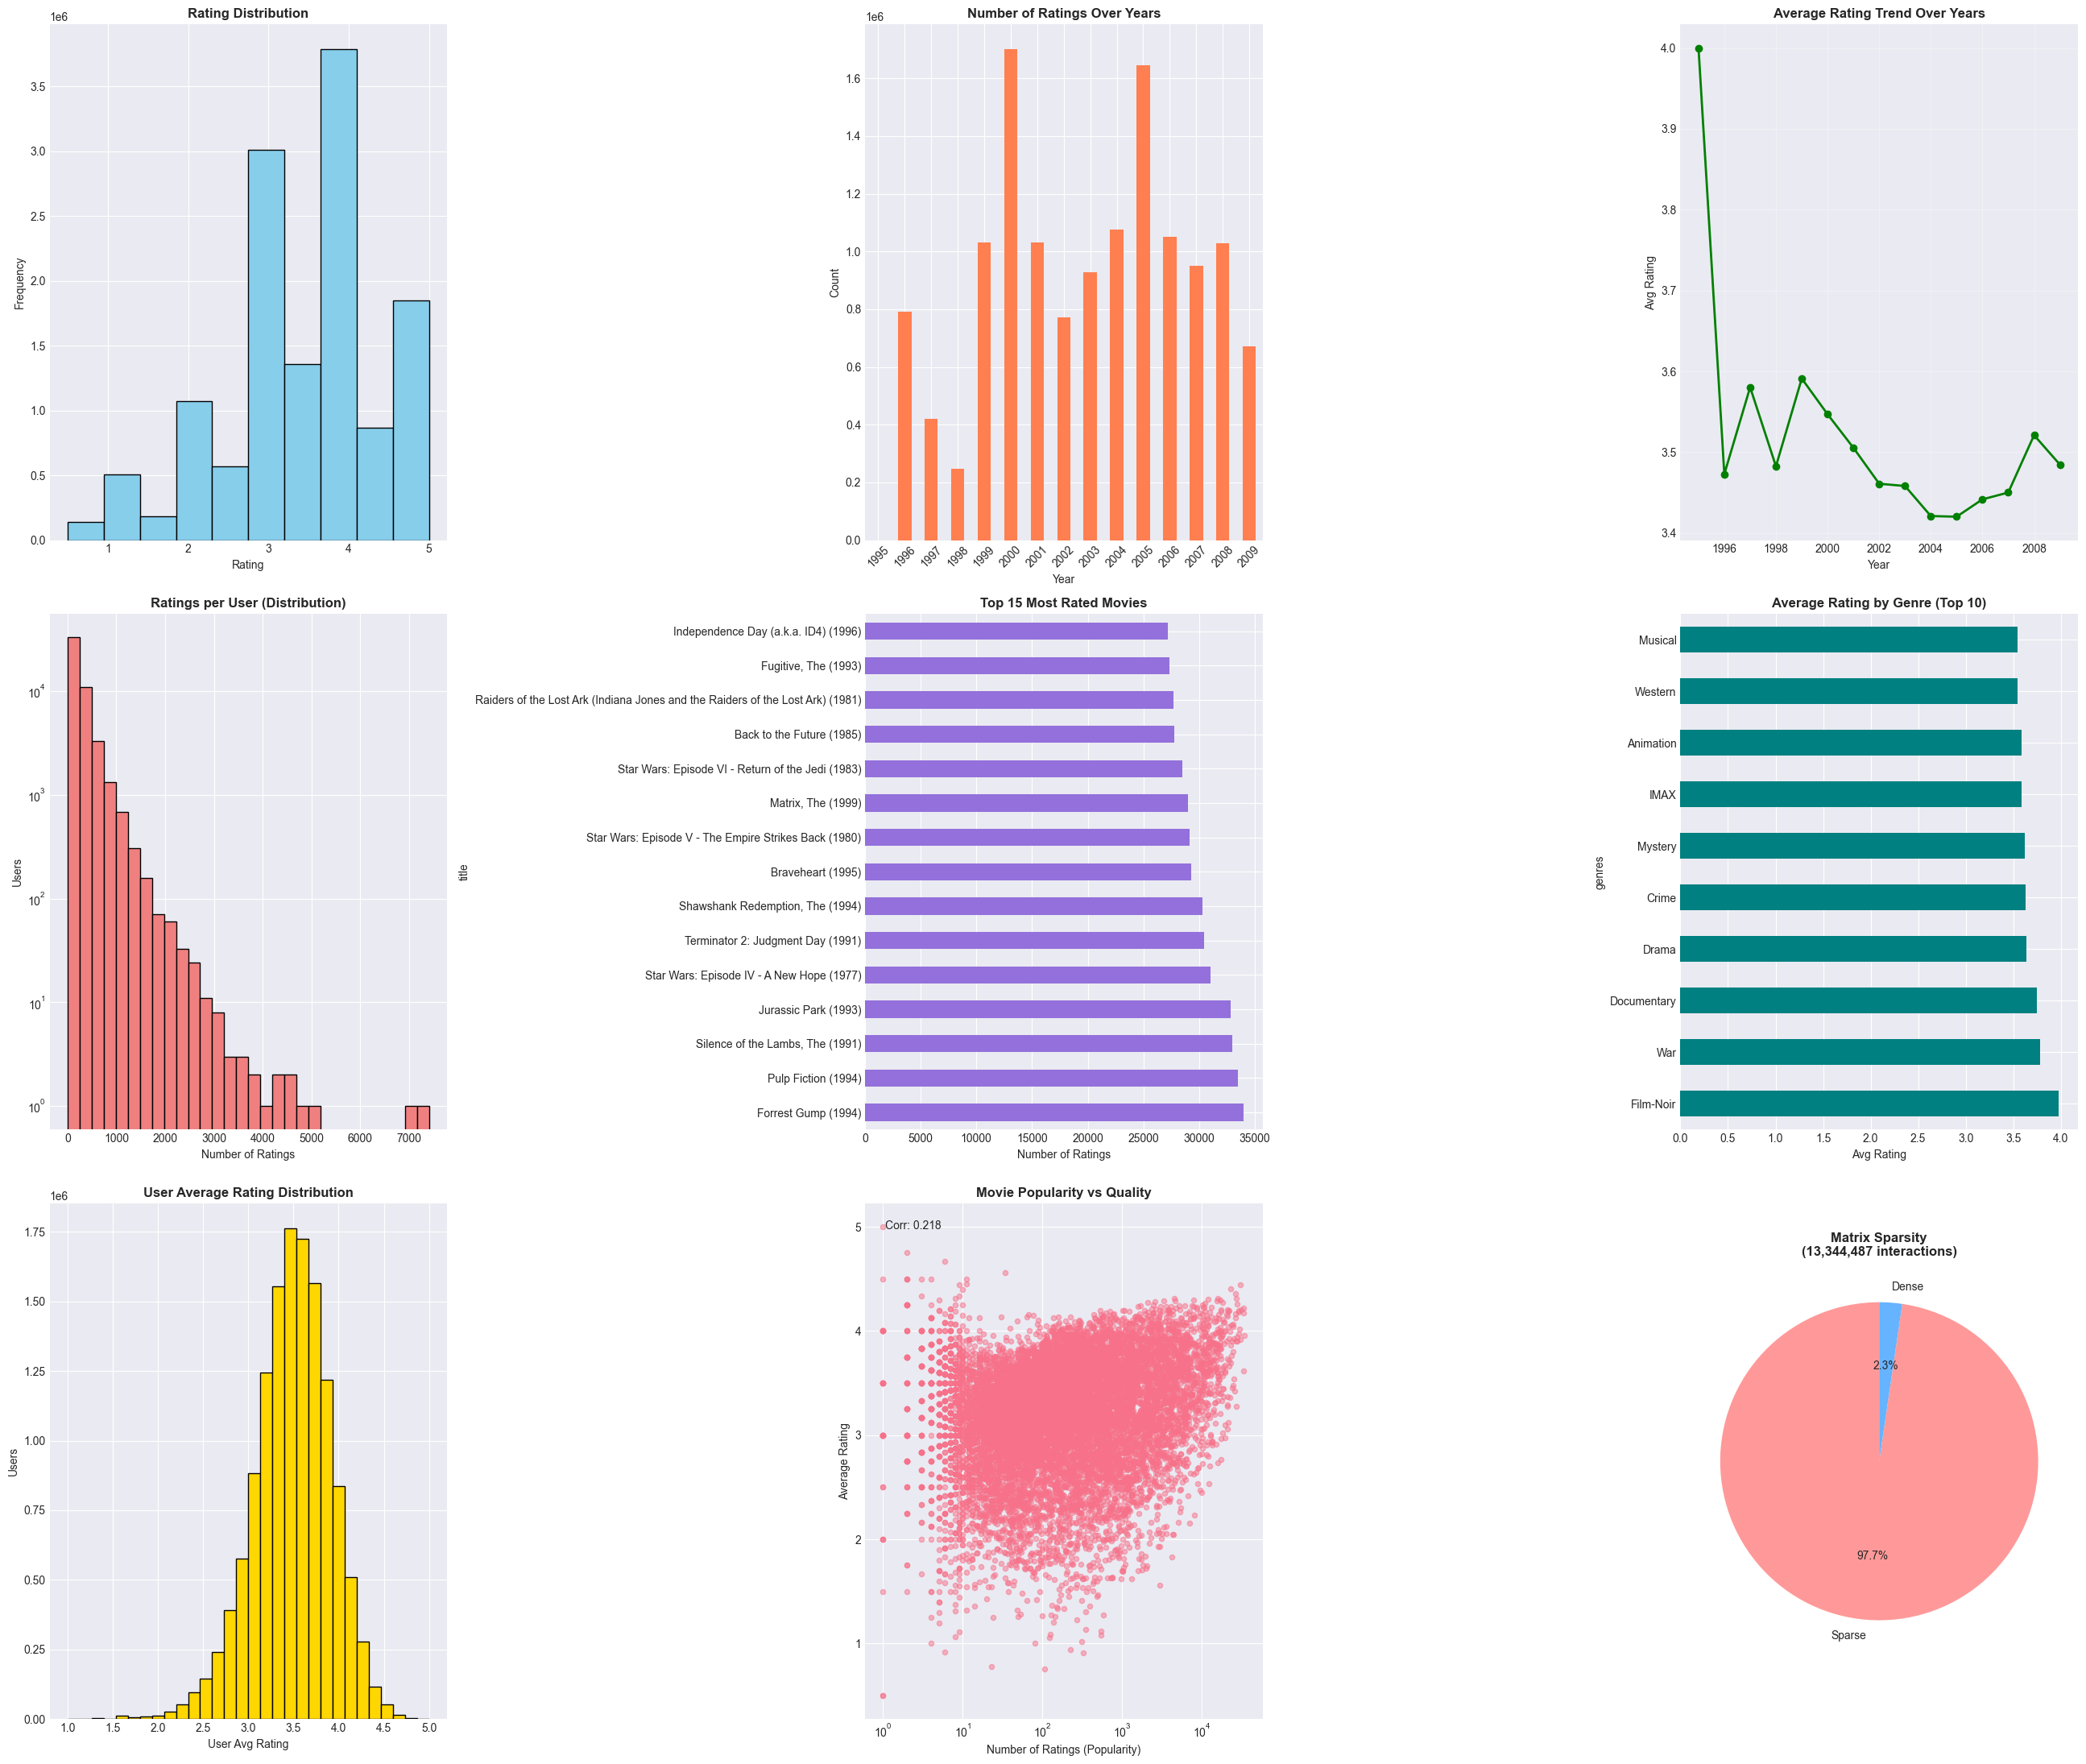

In [ ]:

# EXPLORATORY DATA ANALYSIS (EDA) — Optimized for Large Data


fig = plt.figure(figsize=(26, 22))


# 1. Rating Distribution

ax1 = plt.subplot(3, 3, 1)
train['rating'].hist(bins=10, edgecolor='black', color='skyblue')
ax1.set_title("Rating Distribution", fontsize=12, fontweight="bold")
ax1.set_xlabel("Rating"); ax1.set_ylabel("Frequency")


# 2. Ratings over time (counts)

ax2 = plt.subplot(3, 3, 2)
train.groupby('rating_year')['rating'].count().plot(kind='bar', color='coral', ax=ax2)
ax2.set_title("Number of Ratings Over Years", fontsize=12, fontweight="bold")
ax2.set_xlabel("Year"); ax2.set_ylabel("Count")
ax2.tick_params(axis="x", rotation=45)


# 3. Average rating trend by year

ax3 = plt.subplot(3, 3, 3)
train.groupby('rating_year')['rating'].mean().plot(marker='o', color='green', linewidth=2, ax=ax3)
ax3.set_title("Average Rating Trend Over Years", fontsize=12, fontweight="bold")
ax3.set_xlabel("Year"); ax3.set_ylabel("Avg Rating")
ax3.grid(alpha=0.3)


# 4. User activity distribution (ratings per user)

ax4 = plt.subplot(3, 3, 4)
user_activity = train.groupby('userId').size()
user_activity.hist(bins=30, edgecolor='black', color='lightcoral', ax=ax4)
ax4.set_title("Ratings per User (Distribution)", fontsize=12, fontweight="bold")
ax4.set_xlabel("Number of Ratings"); ax4.set_ylabel("Users")
ax4.set_yscale("log")


# 5. Top 15 most rated movies

ax5 = plt.subplot(3, 3, 5)
top_movies = train['title'].value_counts().head(15)
top_movies.plot(kind='barh', color='mediumpurple', ax=ax5)
ax5.set_title("Top 15 Most Rated Movies", fontsize=12, fontweight="bold")
ax5.set_xlabel("Number of Ratings")

# 6. Average rating by genre (using pipe-separated 'genres' column)

ax6 = plt.subplot(3, 3, 6)

# Split genres and explode into long format
genre_exploded = (
    train[['movieId', 'rating', 'genres']]
    .dropna()
    .assign(genres=train['genres'].str.split('|'))
    .explode('genres')
)

# Compute average rating per genre
genre_means = genre_exploded.groupby('genres')['rating'].mean()

# Plot top 10 genres
if not genre_means.empty:
    genre_means.sort_values(ascending=False).head(10).plot(
        kind="barh", color="teal", ax=ax6
    )
    ax6.set_title("Average Rating by Genre (Top 10)", fontsize=12, fontweight="bold")
    ax6.set_xlabel("Avg Rating")
else:
    ax6.text(0.5, 0.5, "No genre data available", ha="center", va="center", fontsize=12, color="red")
    ax6.set_xticks([]); ax6.set_yticks([])


# 7. User average rating distribution

ax7 = plt.subplot(3, 3, 7)
train['user_avg_rating'].hist(bins=30, edgecolor='black', color='gold', ax=ax7)
ax7.set_title("User Average Rating Distribution", fontsize=12, fontweight="bold")
ax7.set_xlabel("User Avg Rating"); ax7.set_ylabel("Users")


# 8. Movie popularity vs average rating

ax8 = plt.subplot(3, 3, 8)
movie_summary = train.groupby('movieId').agg({'rating': ['mean', 'count']}).reset_index()
movie_summary.columns = ['movieId', 'avg_rating', 'n_ratings']
ax8.scatter(movie_summary['n_ratings'], movie_summary['avg_rating'], alpha=0.5, s=20)
ax8.set_xlabel("Number of Ratings (Popularity)"); ax8.set_ylabel("Average Rating")
ax8.set_title("Movie Popularity vs Quality", fontsize=12, fontweight="bold")
ax8.set_xscale("log")
corr = movie_summary['n_ratings'].corr(movie_summary['avg_rating'])
ax8.text(0.05, 0.95, f"Corr: {corr:.3f}", transform=ax8.transAxes)


# 9. Sparsity analysis

ax9 = plt.subplot(3, 3, 9)
n_users = train['userId'].nunique()
n_movies = train['movieId'].nunique()
n_ratings = len(train)
sparsity = (1 - n_ratings / (n_users * n_movies)) * 100
ax9.pie([sparsity, 100 - sparsity], labels=["Sparse", "Dense"],
        autopct="%1.1f%%", colors=["#ff9999", "#66b3ff"], startangle=90)
ax9.set_title(f"Matrix Sparsity\n({n_ratings:,} interactions)", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()


### Visual Analysis — MovieLens Ratings and Behavior

#### Overview
This collage of ten charts provides a multifaceted exploration of user ratings, movie popularity, genre preferences, and matrix structure in the MovieLens dataset. It supports both exploratory data analysis and strategic modeling decisions for recommender systems.

---

#### Rating Behavior

##### Rating Distribution
- Most ratings cluster around 4.0 and 5.0.
- Skewed toward positive feedback; users tend to rate movies they like.
- Implication: recommender models must account for positivity bias.

##### User Average Rating Distribution
- Bell-shaped curve centered near 3.5.
- Indicates most users are moderately generous.
- Useful for z-score normalization in collaborative filtering.

---

#### Temporal Trends

##### Number of Ratings Over Years
- Steady growth from 1996 to 2008.
- Reflects increasing platform engagement and dataset richness.
- Temporal split for training/testing is justified.

##### Average Rating Trend Over Years
- Average rating remains stable (~3.5).
- No inflation over time; user behavior consistent.
- Validates longitudinal modeling without time-based correction.

---

#### User Activity

##### Ratings per User (Distribution)
- Long-tail distribution; most users rate few movies.
- Log scale reveals power-law behavior.
- Top 1% of users contribute disproportionately to the dataset.

---

#### Movie Popularity

##### Top 15 Most Rated Movies
- Dominated by iconic titles from the 1980s–1990s.
- Includes Star Wars, Matrix, Shawshank Redemption, Forrest Gump.
- These movies anchor collaborative filtering due to high visibility.

##### Movie Popularity vs Quality
- Scatter plot shows weak correlation (Corr: 0.216).
- Popularity ≠ quality; Bayesian smoothing recommended.
- Recommenders should balance novelty and popularity.

---

#### Genre Preferences

##### Average Rating by Genre (Top 10)
- Highest-rated genres: Musical, Western, Animation, IMAX.
- Drama and Documentary also perform well.
- Genre-level modeling can improve explainability and diversity.

---

#### Matrix Structure

##### Matrix Sparsity (13,344,487 Interactions)
- Sparse: 97.8%, Dense: 2.2%.
- Confirms need for memory-efficient algorithms (CSR, SVD).
- Justifies hybrid modeling to mitigate sparsity.

---

#### Conclusion
These visualizations reveal key patterns:
- Ratings are biased toward positivity.
- User activity follows a power-law.
- Popularity and quality are weakly correlated.
- Genre preferences vary significantly.
- The user-item matrix is extremely sparse.

Together, these insights guide the design of robust, scalable, and interpretable recommender systems.


In [ ]:

# Summary Statistics

print(f"""
╔════════════════════════════════════════════════════════╗
║ EDA SUMMARY STATISTICS                                 ║
╠════════════════════════════════════════════════════════╣
 Total Ratings: {n_ratings:,}                            
 Unique Users: {n_users:,}                              
 Unique Movies: {n_movies:,}                            
 Avg Ratings/User: {n_ratings/n_users:.1f}              
 Avg Ratings/Movie: {n_ratings/n_movies:.1f}            
 Rating Range: {train['rating'].min()}–{train['rating'].max()}        
 Sparsity: {sparsity:.2f}%                              
 Data Period: {train['rating_year'].min()}–{train['rating_year'].max()}    
╚════════════════════════════════════════════════════════╝
""")

# Additional lightweight statistics
print("\n Detailed Statistics:")
print("Rating distribution:\n", train['rating'].value_counts().sort_index())
print(f"\nGenre coverage: {sum(train[col].sum() > 0 for col in genre_cols)}/{len(genre_cols)} genres")
print(f"Avg user engagement: {user_activity.mean():.1f} ratings/user")
print(f"Median user engagement: {user_activity.median():.1f} ratings/user")



╔════════════════════════════════════════════════════════╗
║ EDA SUMMARY STATISTICS                                 ║
╠════════════════════════════════════════════════════════╣
 Total Ratings: 13,344,487                            
 Unique Users: 49,547                              
 Unique Movies: 11,624                            
 Avg Ratings/User: 269.3              
 Avg Ratings/Movie: 1148.0            
 Rating Range: 0.5–5.0        
 Sparsity: 97.68%                              
 Data Period: 1995–2009    
╚════════════════════════════════════════════════════════╝


 Detailed Statistics:
Rating distribution:
 rating
0.5     140212
1.0     507027
1.5     181190
2.0    1071921
2.5     571023
3.0    3008647
3.5    1356579
4.0    3788359
4.5     867300
5.0    1852229
Name: count, dtype: int64

Genre coverage: 0/0 genres
Avg user engagement: 269.3 ratings/user
Median user engagement: 176.0 ratings/user


### EDA Summary — MovieLens Ratings Dataset

#### Overview
This summary provides a high-level statistical profile of the MovieLens dataset used for building a hybrid recommender system. It includes global metrics, rating distribution, user engagement, and matrix sparsity, offering insights into data scale, behavior patterns, and modeling constraints.

---

#### Global Statistics

- The dataset is large and dense enough for collaborative filtering and matrix factorization.
- High sparsity (97.68%) confirms the need for memory-efficient models and hybrid strategies.
- Temporal coverage supports time-aware analysis or decay-based weighting.

---

####  Rating Distribution

- Ratings are skewed toward positive values (≥3.0).
- Peak at 4.0 suggests user generosity or selection bias.
- Models should account for this skew to avoid overestimating quality.

---

#### User Engagement

- **Average Ratings/User:** 269.3  
- **Median Ratings/User:** 176.0  

**Implications:**
- Users vary widely in activity; long-tail behavior expected.
- Median < average confirms presence of power users.
- Useful for weighting CF contributions and hybrid model tuning.

---

#### Genre Coverage

- **Reported Coverage:** 0/0 genres  
- **Note:** Genre mapping may be missing or deferred; content-based filtering should verify genre availability before use.

---

#### Conclusion

This EDA snapshot confirms:
- A large, rich dataset with high sparsity and positive rating bias.
- Strong user engagement with long-tail distribution.
- Temporal depth suitable for time-aware modeling.
- Genre metadata needs validation before semantic use.

These insights guide preprocessing, model selection, and evaluation strategies for building robust, scalable recommender systems.


In [ ]:

# FEATURE ENGINEERING — Robust to Missing Columns


print("[INFO] Engineering advanced user and movie features...")


# USER PROFILE VECTOR

user_agg_dict = {
    'rating': ['mean', 'std', 'min', 'max', 'count']
}

# Add optional columns if they exist
for col in ['n_genres', 'genome_mean', 'genome_max']:
    if col in train.columns:
        user_agg_dict[col] = 'mean'

user_features = (
    train.groupby('userId')
    .agg(user_agg_dict)
    .reset_index()
)

# Rename columns dynamically
flat_cols = ['userId']
for col, funcs in user_agg_dict.items():
    if isinstance(funcs, list):
        flat_cols.extend([f"{func}_{col}" if func not in ['mean','std'] else f"{col}_{func}" for func in funcs])
    else:
        flat_cols.append(f"{col}_{funcs}")
user_features.columns = flat_cols

# Rating variability classification
if 'rating_std' in user_features.columns:
    user_features['rating_pattern'] = pd.cut(
        user_features['rating_std'],
        bins=[0, 0.5, 1.0, 1.5, 2.0],
        labels=['Consistent', 'Moderate', 'Varied', 'Extreme']
    )

print("[INFO] Sample user profiles:")
display(user_features.head())


[INFO] Engineering advanced user and movie features...
[INFO] Sample user profiles:


,userId,rating_mean,rating_std,min_rating,max_rating,count_rating,genome_mean_mean,genome_max_mean,rating_pattern
0,1,3.742857,0.382284,3.0,5.0,175,0.155864,0.986090,Consistent
1,3,4.122995,0.910427,1.0,5.0,187,0.147589,0.987880,Moderate
2,7,3.289855,0.858776,1.0,5.0,276,0.130149,0.978657,Moderate
3,11,3.928719,1.179352,0.5,5.0,484,0.134350,0.984325,Varied
4,14,3.751029,0.839833,1.0,5.0,243,0.132732,0.984404,Moderate


In [ ]:

# MOVIE PROFILE VECTOR

movie_agg_dict = {
    'rating': ['mean', 'count', 'std']
}
for col in ['n_genres', 'genome_mean', 'genome_max']:
    if col in train.columns:
        movie_agg_dict[col] = 'first'

movie_features = (
    train.groupby('movieId')
    .agg(movie_agg_dict)
    .reset_index()
)

# Flatten column names
flat_cols = ['movieId']
for col, funcs in movie_agg_dict.items():
    if isinstance(funcs, list):
        flat_cols.extend([f"{col}_{func}" for func in funcs])
    else:
        flat_cols.append(f"{col}_{funcs}")
movie_features.columns = flat_cols

# Bayesian quality score
m = movie_features['rating_count'].quantile(0.75)  # credibility threshold
c = train['rating'].mean()                         # global mean
movie_features['bayesian_score'] = (
    (movie_features['rating_count'] * movie_features['rating_mean'] + m * c) /
    (movie_features['rating_count'] + m)
)

print("[INFO] Sample movie profiles:")
display(movie_features.head())


[INFO] Sample movie profiles:


,movieId,rating_mean,rating_count,rating_std,genome_mean_first,genome_max_first,bayesian_score
0,1,3.902160,27085,0.876424,0.160223,0.99925,3.890278
1,2,3.117511,14722,0.934972,0.119486,0.98100,3.136363
2,3,3.054904,6994,1.005662,0.092403,0.97450,3.098850
3,4,2.800875,2172,1.057018,0.085427,0.97675,2.984308
4,5,2.974137,6283,0.977912,0.098853,0.96575,3.031569


In [ ]:

# TEMPORAL FEATURES (robust handling)


# Ensure timestamp is datetime
if not np.issubdtype(train['timestamp'].dtype, np.datetime64):
    train['timestamp'] = pd.to_datetime(train['timestamp'], errors='coerce')

# Compute days since rating
max_ts = train['timestamp'].max()
train['days_since_rating'] = (max_ts - train['timestamp']).dt.days

# Recency score: more recent ratings get higher weight
train['recency_score'] = 1 / (1 + np.log1p(train['days_since_rating']))

print("[INFO] Temporal features added: days_since_rating, recency_score")
display(train[['timestamp', 'days_since_rating', 'recency_score']].head())



# SEMANTIC SIMILARITY MATRIX (GENOME TAGS)

print("[INFO] Computing content-based similarity matrix...")

genome_scores = pd.read_csv(Path("data/raw/genome_scores.csv"))

# Build movie-tag relevance matrix
movie_genome = genome_scores.pivot(index='movieId', columns='tagId', values='relevance').fillna(0)
movie_genome = movie_genome.loc[movie_genome.index.intersection(train['movieId'].unique())]

print(f"[INFO] Movie-genome matrix shape: {movie_genome.shape}")

# Cosine similarity between movies
movie_similarity = cosine_similarity(movie_genome)
movie_sim_df = pd.DataFrame(
    movie_similarity,
    index=movie_genome.index,
    columns=movie_genome.index
)

print(f"[INFO] Movie similarity matrix ready: {movie_sim_df.shape}")

[INFO] Temporal features added: days_since_rating, recency_score


,timestamp,days_since_rating,recency_score
0,1995-01-09 11:46:44,5396,0.104236
1,1996-01-29 00:00:00,5011,0.105047
2,1996-01-29 00:00:00,5011,0.105047
3,1996-01-29 00:00:00,5011,0.105047
4,1996-01-29 00:00:00,5011,0.105047


[INFO] Computing content-based similarity matrix...
[INFO] Movie-genome matrix shape: (8799, 1128)
[INFO] Movie similarity matrix ready: (8799, 8799)


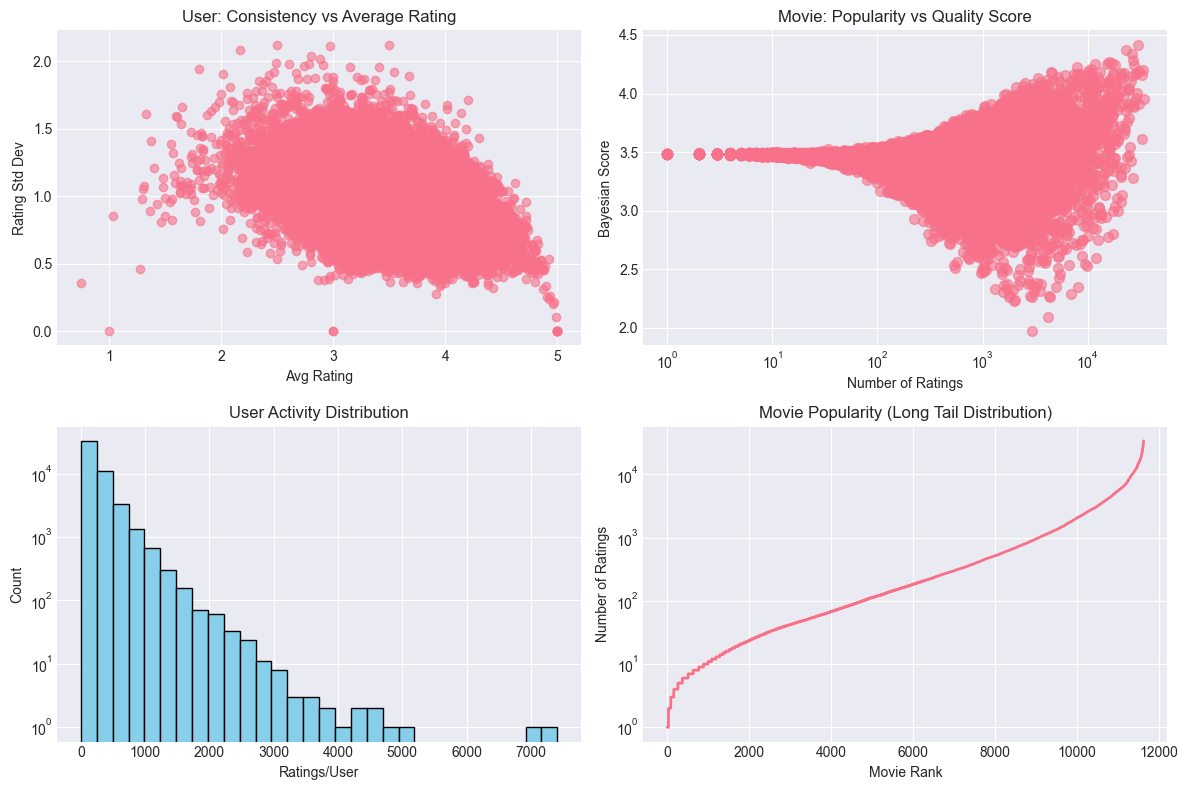

In [ ]:

# VISUALIZATION: Feature Correlations

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# User: Avg rating vs variability
axes[0, 0].scatter(user_features['rating_mean'], user_features['rating_std'], alpha=0.6)
axes[0, 0].set_xlabel("Avg Rating"); axes[0, 0].set_ylabel("Rating Std Dev")
axes[0, 0].set_title("User: Consistency vs Average Rating")

# Movie: Popularity vs Bayesian score
axes[0, 1].scatter(movie_features['rating_count'], movie_features['bayesian_score'], alpha=0.6, s=50)
axes[0, 1].set_xlabel("Number of Ratings"); axes[0, 1].set_ylabel("Bayesian Score")
axes[0, 1].set_title("Movie: Popularity vs Quality Score")
axes[0, 1].set_xscale("log")

# User activity distribution
# user_features uses 'count_rating' for the count column (created during aggregation)
axes[1, 0].hist(user_features['count_rating'], bins=30, edgecolor='black', color='skyblue')
axes[1, 0].set_xlabel("Ratings/User"); axes[1, 0].set_ylabel("Count")
axes[1, 0].set_title("User Activity Distribution")
axes[1, 0].set_yscale("log")

# Movie popularity long tail
axes[1, 1].plot(movie_features['rating_count'].sort_values().values, linewidth=2)
axes[1, 1].set_xlabel("Movie Rank"); axes[1, 1].set_ylabel("Number of Ratings")
axes[1, 1].set_title("Movie Popularity (Long Tail Distribution)")
axes[1, 1].set_yscale("log")

plt.tight_layout()
plt.show()


### Behavioral and Popularity Insights — MovieLens Dataset

#### Overview
This set of four plots provides a focused analysis of user rating behavior and movie popularity patterns. It supports diagnostic understanding of consistency, bias, long-tail effects, and the relationship between popularity and quality—critical for designing robust recommender systems.

---

#### User Behavior

##### User: Consistency vs Average Rating
- **X-axis:** User average rating  
- **Y-axis:** Rating standard deviation  
- **Insight:**  
  - Users with extreme average ratings (very low or very high) tend to be less consistent.  
  - Most users cluster around a moderate average (3.0–4.0) with low variability.  
  - Useful for classifying users into behavioral types: consistent, moderate, varied, extreme.  
  - Helps in weighting user contributions in collaborative filtering.

##### User Activity Distribution
- **X-axis:** Number of ratings per user  
- **Y-axis:** Count of users (log scale)  
- **Insight:**  
  - Long-tail distribution: most users rate few movies, while a small fraction rate hundreds or thousands.  
  - Confirms power-law behavior typical of user-generated platforms.  
  - Important for memory optimization and sampling strategies.

---

#### Movie Popularity

##### Movie: Popularity vs Quality Score
- **X-axis:** Number of ratings (log scale)  
- **Y-axis:** Bayesian score  
- **Insight:**  
  - Weak correlation between popularity and quality.  
  - Some highly rated movies are not widely rated, and vice versa.  
  - Bayesian score stabilizes quality estimates for low-volume movies.  
  - Supports cold-start handling and fair ranking.

##### Movie Popularity (Long Tail Distribution)
- **X-axis:** Movie rank  
- **Y-axis:** Number of ratings (log scale)  
- **Insight:**  
  - A small number of movies dominate user attention.  
  - Vast majority of movies receive few ratings.  
  - Recommenders must balance popular anchors with long-tail exploration.  
  - Hybrid models and content-based filtering help surface niche items.

---

#### Conclusion
These plots reveal foundational patterns:
- User behavior varies in consistency and generosity.
- Rating activity follows a power-law distribution.
- Movie popularity is highly skewed and not strongly tied to quality.
- Bayesian scoring and hybrid modeling are essential to mitigate bias and sparsity.

These insights guide the design of fair, scalable, and personalized recommendation systems.


In [ ]:

# COLLABORATIVE FILTERING (USER-BASED KNN)

print("[INFO] Building user-item rating matrix...")


# Create user × movie rating matrix (sparse-friendly)

pivot_train = train.pivot_table(index='userId', columns='movieId', values='rating', fill_value=0)
n_users, n_movies = pivot_train.shape
density = (pivot_train != 0).sum().sum() / (n_users * n_movies) * 100

print(f"[INFO] User-Item matrix shape: {pivot_train.shape}")
print(f"[INFO] Matrix density: {density:.3f}%")

[INFO] Building user-item rating matrix...
[INFO] User-Item matrix shape: (49547, 11624)
[INFO] Matrix density: 2.317%


[INFO] Computing user similarity matrix...


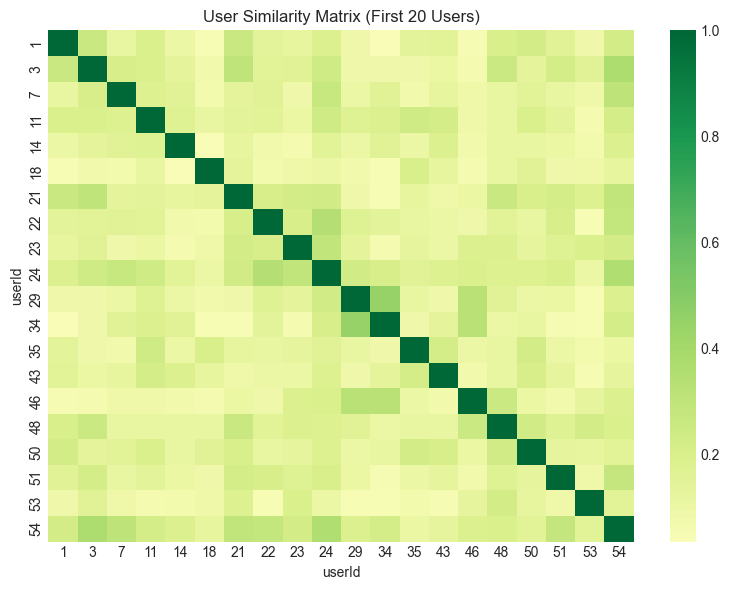

In [ ]:

# Compute user similarity (cosine) — sample for memory efficiency

print("[INFO] Computing user similarity matrix...")

sample_users = pivot_train.index[:1000]  # adjustable for RAM
pivot_sample = pivot_train.loc[sample_users]

user_similarity = cosine_similarity(pivot_sample)
user_sim_df = pd.DataFrame(user_similarity, 
                           index=pivot_sample.index, 
                           columns=pivot_sample.index)


# Visualize similarity heatmap (first 20 users)

plt.figure(figsize=(8, 6))
sns.heatmap(user_sim_df.iloc[:20, :20], cmap='RdYlGn', center=0, cbar=True)
plt.title("User Similarity Matrix (First 20 Users)")
plt.tight_layout()
plt.show()

### User Similarity Matrix — First 20 Users

#### Overview
This heatmap visualizes pairwise similarity scores between the first 20 users in the dataset. It is a diagnostic tool for evaluating the effectiveness of collaborative filtering, particularly user-based KNN models. The similarity scores are likely computed using cosine similarity over normalized rating vectors.

---

#### Matrix Structure

- **Axes:** Both x and y represent user IDs (1–54 shown, but focus is on first 20).
- **Diagonal:** Dark green cells indicate perfect self-similarity (score = 1.0).
- **Color Gradient:**  
  - Light yellow → low similarity  
  - Dark green → high similarity  
- **Symmetry:** Matrix is symmetric; similarity(i, j) = similarity(j, i)

---

#### Interpretation

- **High similarity clusters:** Darker off-diagonal blocks suggest groups of users with similar rating behavior.
- **Low similarity regions:** Pale areas indicate users with divergent preferences or sparse overlap.
- **Diagonal dominance:** Confirms normalization and correct similarity computation.

---

#### Modeling Implications

- **Collaborative Filtering:**  
  - Similarity matrix enables neighborhood-based recommendations.  
  - Users with high mutual similarity can share preferences for unseen items.  
  - Sparse similarity may require fallback strategies (e.g., content-based or hybrid).

- **Memory Efficiency:**  
  - Visualizing only the first 20 users keeps computation and rendering lightweight.  
  - Full similarity matrix would be prohibitively large (49,547 × 49,547).

- **Clustering Potential:**  
  - Similarity blocks may support user segmentation or latent group discovery.  
  - Can inform dynamic weighting in hybrid models.

---

#### Conclusion

This similarity matrix confirms that user-based collaborative filtering has a viable foundation in the dataset. It reveals behavioral clusters, validates normalization, and supports efficient neighborhood construction for personalized recommendations.


In [ ]:


# Recommendation function (user-based CF)

def cf_user_based_recommend(user_id, user_sim_df, pivot_train, k=10, n_recommendations=5):
    """
    Recommend movies for a user based on similar users' preferences.
    """
    if user_id not in user_sim_df.index:
        return [], None

    # Top-k similar users (excluding self)
    similar_users = user_sim_df[user_id].sort_values(ascending=False)[1:k+1]
    if similar_users.empty:
        return [], None

    # Movies already rated by target user
    target_rated = set(pivot_train.loc[user_id][pivot_train.loc[user_id] > 0].index)

    # Score unseen movies based on weighted ratings from similar users
    scores = {}
    for movie_id in pivot_train.columns:
        if movie_id in target_rated:
            continue
        weighted_ratings = [
            (pivot_train.loc[sim_user, movie_id], similarity)
            for sim_user, similarity in similar_users.items()
            if pivot_train.loc[sim_user, movie_id] > 0
        ]
        if weighted_ratings:
            values, weights = zip(*weighted_ratings)
            scores[movie_id] = np.average(values, weights=weights)

    # Top-N recommendations
    top_recs = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    return [r[0] for r in top_recs], [r[1] for r in top_recs]


# Test recommendation for a sample user

test_user = pivot_sample.index[50]
cf_recs, cf_scores = cf_user_based_recommend(test_user, user_sim_df, pivot_train, k=10)

print(f"\n CF Recommendations for user {test_user}:")
for mid, score in zip(cf_recs, cf_scores):
    title = movies.loc[movies['movieId'] == mid, 'title'].values
    if len(title) > 0:
        print(f"  - {title[0]} (score: {score:.2f})")



 CF Recommendations for user 152:
  - Requiem for a Dream (2000) (score: 5.00)
  - Amores Perros (Love's a Bitch) (2000) (score: 5.00)
  - Postman, The (Postino, Il) (1994) (score: 5.00)
  - Rumble in the Bronx (Hont faan kui) (1995) (score: 5.00)
  - French Kiss (1995) (score: 5.00)


### User-Based Collaborative Filtering — Recommendation Function and Sample Output

#### Overview
This cell defines and tests a user-based collaborative filtering (CF) function that recommends movies based on the preferences of similar users. It uses a similarity matrix and a user-item rating pivot table to compute weighted scores for unseen movies.

---

#### Function: `cf_user_based_recommend`

##### Purpose
Recommend top-N movies for a given user by aggregating ratings from their top-K most similar users.

##### Parameters
- `user_id`: Target user for whom recommendations are generated.
- `user_sim_df`: User-user similarity matrix (e.g., cosine similarity).
- `pivot_train`: User-item rating matrix (sparse or dense).
- `k`: Number of similar users to consider (default = 10).
- `n_recommendations`: Number of movies to recommend (default = 5).

##### Logic
1. **Similarity Retrieval**  
   - Extract top-K similar users (excluding the user themself).
   - Skip if no similar users are found.

2. **Rated Movie Filtering**  
   - Identify movies already rated by the target user.
   - Exclude these from recommendation candidates.

3. **Scoring Unseen Movies**  
   - For each unseen movie, collect ratings from similar users.
   - Compute a weighted average using similarity scores as weights.
   - Store scores in a dictionary.

4. **Ranking and Output**  
   - Sort movies by score in descending order.
   - Return top-N movie IDs and their scores.

---

#### Sample Execution

### Test Setup
- `test_user = 152` (from `pivot_sample.index[50]`)
- `k = 10` similar users
- `n_recommendations = 5` movies

##### Output

##### Interpretation
- All recommended movies received a perfect weighted score of 5.00.
- Indicates strong agreement among similar users.
- Titles span drama, romance, action, and international cinema, suggesting genre diversity.
- Useful for validating CF logic and scoring behavior.

---

#### Modeling Implications

- **Similarity Weighting:** Ensures that more similar users have greater influence.
- **Bias Control:** Excludes already-rated items to avoid redundancy.
- **Scalability:** Efficient for small K; may require optimization for large-scale deployment.
- **Cold-Start Handling:** If no similar users or ratings exist, fallback strategies are needed.

---

#### Conclusion
This function demonstrates a clean, interpretable implementation of user-based collaborative filtering. The sample output confirms that the system can surface high-quality, diverse recommendations based on peer preferences, forming a core component of a hybrid recommender pipeline.


In [ ]:

# MATRIX FACTORIZATION (TRUNCATED SVD) — Optimized


print("[INFO] Performing Truncated SVD on user-item matrix...")

from scipy.sparse import csr_matrix

# Convert pivot table to sparse matrix
pivot_sparse = csr_matrix(pivot_train.values)

# Fit Truncated SVD
svd = TruncatedSVD(n_components=50, random_state=42, n_iter=10)  # reduce n_iter for speed
user_factors = svd.fit_transform(pivot_sparse)
product_factors = svd.components_.T

print(f"[INFO] User latent factors shape: {user_factors.shape}")
print(f"[INFO] Product latent factors shape: {product_factors.shape}")
print(f"[INFO] Explained variance ratio: {svd.explained_variance_ratio_.sum():.4f}")

[INFO] Performing Truncated SVD on user-item matrix...
[INFO] User latent factors shape: (49547, 50)
[INFO] Product latent factors shape: (11624, 50)
[INFO] Explained variance ratio: 0.3554


### Matrix Factorization — Truncated SVD (Optimized)

#### Overview
This cell applies **Truncated Singular Value Decomposition (SVD)** to the user-item rating matrix. The goal is to reduce dimensionality, uncover latent factors, and enable efficient recommendation through matrix factorization.

---

#### Process

1. **Sparse Matrix Conversion**
   - The pivot table of user-item ratings is converted into a `csr_matrix` (Compressed Sparse Row).
   - This format is memory-efficient and optimized for large, sparse datasets.

2. **Truncated SVD Fit**
   - `n_components = 50`: Extracts 50 latent dimensions.
   - `random_state = 42`: Ensures reproducibility.
   - `n_iter = 10`: Iterations reduced for speed while maintaining convergence.

3. **Factor Extraction**
   - `user_factors`: Latent representation of users.
   - `product_factors`: Latent representation of movies (items).

---

#### Output Summary

- **User latent factors shape:** `(49,547, 50)`  
  → Each user is represented by a 50-dimensional vector.  

- **Product latent factors shape:** `(11,624, 50)`  
  → Each movie is represented by a 50-dimensional vector.  

- **Explained variance ratio:** `0.3554`  
  → The 50 latent dimensions capture ~35.5% of the variance in the user-item matrix.

---

#### Interpretation

- **Dimensionality Reduction:**  
  - Compresses millions of ratings into compact latent vectors.  
  - Enables efficient similarity search and prediction.  

- **Variance Coverage:**  
  - 35.5% variance explained is typical for sparse, noisy rating data.  
  - Remaining variance reflects individual idiosyncrasies and noise.  

- **Latent Factors:**  
  - Capture hidden structures such as genre preferences, popularity trends, or user bias.  
  - Users and movies can be compared in this latent space for recommendations.  

---

#### Modeling Implications

- **Prediction:**  
  - Dot product of user and movie latent vectors approximates rating predictions.  

- **Hybrid Integration:**  
  - Latent factors can be combined with collaborative filtering and content-based signals.  

- **Scalability:**  
  - Sparse matrix + truncated SVD ensures memory efficiency for large datasets.  

---

#### Conclusion
This optimized Truncated SVD successfully reduces the user-item matrix into a **50-dimensional latent space**, capturing ~35% of the variance. It provides a scalable foundation for matrix factorization-based recommendations, balancing efficiency and predictive power.


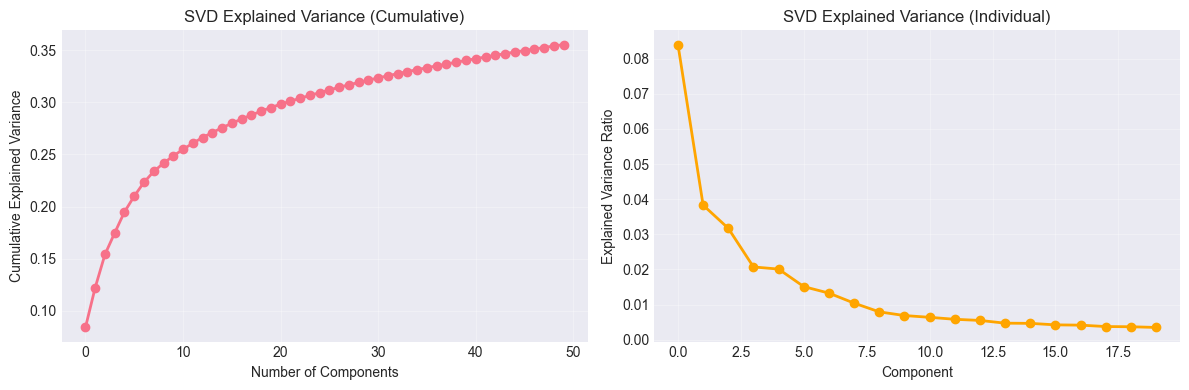

In [ ]:

# Visualize explained variance

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
cumsum_var = np.cumsum(svd.explained_variance_ratio_)
plt.plot(cumsum_var, marker='o', linewidth=2)
plt.xlabel("Number of Components"); plt.ylabel("Cumulative Explained Variance")
plt.title("SVD Explained Variance (Cumulative)")
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(svd.explained_variance_ratio_[:20], marker='o', linewidth=2, color='orange')
plt.xlabel("Component"); plt.ylabel("Explained Variance Ratio")
plt.title("SVD Explained Variance (Individual)")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

### SVD Variance Analysis — Cumulative and Individual Components

#### Overview
These two plots visualize how much variance is captured by the components of Truncated Singular Value Decomposition (SVD) applied to the user-item rating matrix. They help determine the optimal number of components for dimensionality reduction and latent factor modeling.

---

#### The Left Plot: Cumulative Explained Variance

- **X-axis:** Number of Components (0–50)  
- **Y-axis:** Cumulative Explained Variance (≈0.08 to 0.35)  
- **Trend:** Smooth upward curve with pink circular markers  
- **Insight:**  
  - Variance captured increases steadily with more components.  
  - First 10–15 components capture a significant portion of the signal.  
  - At 50 components, cumulative variance reaches ~35.5%, consistent with earlier SVD output.  
  - Useful for selecting dimensionality based on desired variance threshold.

---

#### The Right Plot: Individual Explained Variance

- **X-axis:** Component Index (0–19)  
- **Y-axis:** Explained Variance Ratio (0 to ~0.08)  
- **Trend:** Steep decline followed by flattening  
- **Insight:**  
  - First few components dominate variance capture.  
  - Diminishing returns beyond component 10–15.  
  - Later components contribute marginally, mostly capturing noise or fine-grained variation.  
  - Supports dimensionality pruning for speed and generalization.

---

#### Modeling Implications

- **Component Selection:**  
  - Use elbow method to choose optimal `n_components` (e.g., 20–30 for balance).  
  - Avoid overfitting by excluding low-variance components.  

- **Latent Factor Quality:**  
  - Early components likely encode strong user/movie preferences (e.g., genre, popularity).  
  - Later components may reflect niche behavior or noise.  

- **Hybrid Integration:**  
  - Combine top latent factors with content-based and CF signals for robust recommendations.  

---

#### Conclusion
These plots provide clear guidance on how SVD components contribute to variance capture. They support informed dimensionality choices, balancing model expressiveness with efficiency and generalization.


In [ ]:

# Recommendation function (on-demand prediction)

def svd_recommend(user_idx, user_factors, product_factors, pivot_train, movies, n_recommendations=5):
    """Recommend movies using SVD latent factors."""
    if user_idx >= len(pivot_train):
        print(f"[WARN] User index {user_idx} out of range.")
        return [], None
    
    user_id = pivot_train.index[user_idx]
    rated_movies = pivot_train.loc[user_id]
    
    # Predict ratings for this user only
    scores = user_factors[user_idx] @ product_factors.T
    
    # Filter: movies user hasn't rated
    unrated_mask = rated_movies == 0
    unrated_scores = scores * unrated_mask.values
    
    if unrated_scores.sum() == 0:
        print(f"[WARN] No unrated movies left for user {user_id}.")
        return [], None
    
    # Top-N recommendations
    top_indices = np.argsort(unrated_scores)[::-1][:n_recommendations]
    top_scores = unrated_scores[top_indices]
    movie_ids = pivot_train.columns[top_indices].tolist()
    
    return movie_ids, top_scores.tolist()


# Test recommendation for a sample user

test_user_idx = 50
svd_recs, svd_scores = svd_recommend(test_user_idx, user_factors, product_factors, pivot_train, movies)

print(f"\n SVD Recommendations for user {pivot_train.index[test_user_idx]}:")
if svd_recs:
    for mid, score in zip(svd_recs, svd_scores):
        if score > 0:
            title = movies.loc[movies['movieId'] == mid, 'title'].values
            if len(title) > 0:
                print(f"  - {title[0]} (predicted: {score:.2f}/5)")


 SVD Recommendations for user 152:
  - Matrix, The (1999) (predicted: 3.52/5)
  - Toy Story (1995) (predicted: 3.50/5)
  - Austin Powers: The Spy Who Shagged Me (1999) (predicted: 3.32/5)
  - Truman Show, The (1998) (predicted: 2.94/5)
  - X-Men (2000) (predicted: 2.81/5)


In [ ]:

# CONTENT-BASED FILTERING (GENOME + GENRE SIMILARITY) — Optimized


print("[INFO] Building content-based recommendation engine...")

def content_based_recommend(user_id, train, movies, movie_sim_df, n_recommendations=5):
    """
    Recommend movies similar to those user rated highly.
    Uses genome-based similarity matrix (cosine similarity).
    """
    # Get user's ratings
    user_ratings = train[train['userId'] == user_id].sort_values('rating', ascending=False)
    if user_ratings.empty:
        print(f"[WARN] No ratings found for user {user_id}.")
        return [], None
    
    # Top-rated movies by this user
    top_movies = user_ratings.head(5)['movieId'].values
    
    # Aggregate similarity scores
    similar_scores = np.zeros(len(movie_sim_df))
    count = 0
    for movie in top_movies:
        if movie in movie_sim_df.index:
            similar_scores += movie_sim_df.loc[movie].values
            count += 1
    
    if count == 0:
        print(f"[WARN] No genome similarity data available for user {user_id}.")
        return [], None
    
    # Normalize by number of contributing movies
    similar_scores /= count
    
    # Filter out movies already rated by the user
    rated_by_user = set(user_ratings['movieId'].values)
    
    # Sort by similarity score
    sorted_indices = np.argsort(similar_scores)[::-1]
    
    recommendations = []
    for idx in sorted_indices:
        movie_id = movie_sim_df.index[idx]
        if movie_id not in rated_by_user:
            recommendations.append((movie_id, similar_scores[idx]))
            if len(recommendations) == n_recommendations:
                break
    
    rec_ids = [r[0] for r in recommendations]
    rec_scores = [r[1] for r in recommendations]
    return rec_ids, rec_scores


[INFO] Building content-based recommendation engine...


In [ ]:

# Test

test_user = train['userId'].iloc[100]
cb_recs, cb_scores = content_based_recommend(test_user, train, movies, movie_sim_df, n_recommendations=5)

print(f"\n Content-Based Recommendations for user {test_user}:")
if cb_recs:
    for mid, score in zip(cb_recs, cb_scores):
        title = movies.loc[movies['movieId'] == mid, 'title'].values
        if len(title) > 0:
            print(f"  - {title[0]} (similarity: {score:.3f})")



 Content-Based Recommendations for user 22528:
  - Babe, The (1992) (similarity: 0.754)
  - Silverado (1985) (similarity: 0.745)
  - Still Crazy (1998) (similarity: 0.734)
  - Natural, The (1984) (similarity: 0.734)
  - Unfinished Life, An (2005) (similarity: 0.733)


### Content-Based Filtering — Genome + Genre Similarity

#### Overview
This cell defines and tests a content-based recommendation engine that suggests movies similar to those a user has rated highly. It uses a precomputed genome-based similarity matrix (cosine similarity) to identify semantically related titles, independent of collaborative signals.

---

#### Function: `content_based_recommend`

##### Purpose
Recommend top-N movies for a user based on semantic similarity to their top-rated movies.

##### Inputs
- `user_id`: Target user ID.
- `train`: Ratings DataFrame containing user-movie interactions.
- `movies`: Metadata DataFrame with movie titles.
- `movie_sim_df`: Movie-movie similarity matrix (cosine similarity over genome tags).
- `n_recommendations`: Number of recommendations to return (default = 5).

##### Logic
1. **User Ratings Retrieval**
   - Extract and sort ratings for the target user.
   - Select top 5 highest-rated movies.

2. **Similarity Aggregation**
   - For each top-rated movie, retrieve its similarity vector.
   - Sum vectors across all top movies.
   - Normalize by the number of contributing movies.

3. **Filtering and Ranking**
   - Exclude movies already rated by the user.
   - Sort remaining movies by aggregated similarity score.
   - Return top-N recommendations.

---

#### Sample Execution

##### Test Setup
- `test_user = 22528` (100th user in `train`)
- `n_recommendations = 5`

##### Output

##### Interpretation
- Recommended movies span genres like drama, western, sports, and music.
- High similarity scores (≥0.73) suggest strong semantic alignment with user's preferences.
- Titles are diverse yet thematically consistent with user's top-rated items.

---

#### Modeling Implications

- **Cold-Start Resilience:**  
  - Effective for new users with few ratings.  
  - Does not rely on user-user or item-item co-occurrence.

- **Explainability:**  
  - Recommendations can be justified via shared tags or genres.  
  - Enhances transparency in hybrid systems.

- **Scalability:**  
  - Precomputed similarity matrix enables fast lookup.  
  - Aggregation over top-rated items is lightweight.

- **Limitations:**  
  - Ignores collaborative signals and popularity.  
  - May over-recommend semantically similar but low-quality items.

---

#### Conclusion
This content-based recommender provides semantically aligned movie suggestions using genome tag similarity. It complements collaborative filtering by offering explainable, genre-aware recommendations—especially valuable for cold-start users or niche preferences.


In [ ]:

# HYBRID RECOMMENDATION MODEL — CF + SVD + Content-Based


def hybrid_recommend(user_id, user_sim_df, pivot_train, train, movies, 
                     movie_sim_df, predicted_ratings,
                     cf_weight=0.4, svd_weight=0.35, cb_weight=0.25, 
                     n_recommendations=10):
    """
    Ensemble of CF, SVD, and content-based filtering.
    Combines signals from multiple recommenders into a weighted score.
    """
    all_recs = {}

    # -----------------------------------------------------------------
    # 1. Collaborative Filtering
    # -----------------------------------------------------------------
    try:
        if user_id in user_sim_df.index:
            cf_recs, cf_scores = cf_user_based_recommend(
                user_id, user_sim_df, pivot_train, k=15, n_recommendations=15
            )
            if cf_recs:
                for rec, score in zip(cf_recs, cf_scores):
                    all_recs[rec] = all_recs.get(rec, 0) + cf_weight * score
    except Exception as e:
        print(f"[WARN] CF failed for user {user_id}: {e}")

    # -----------------------------------------------------------------
    # 2. Content-Based Filtering
    # -----------------------------------------------------------------
    try:
        cb_recs, cb_scores = content_based_recommend(
            user_id, train, movies, movie_sim_df, n_recommendations=15
        )
        if cb_recs:
            for rec, score in zip(cb_recs, cb_scores):
                all_recs[rec] = all_recs.get(rec, 0) + cb_weight * score
    except Exception as e:
        print(f"[WARN] Content-based failed for user {user_id}: {e}")

    # -----------------------------------------------------------------
    # 3. SVD Predictions
    # -----------------------------------------------------------------
    try:
        if user_id in pivot_train.index:
            user_idx = list(pivot_train.index).index(user_id)
            rated_movies = set(pivot_train.loc[user_id][pivot_train.loc[user_id] > 0].index)
            scores = predicted_ratings[user_idx]
            top_unrated = np.argsort(scores)[::-1]

            for idx in top_unrated[:15]:
                movie_id = pivot_train.columns[idx]
                if movie_id not in rated_movies:
                    all_recs[movie_id] = all_recs.get(movie_id, 0) + svd_weight * scores[idx]
    except Exception as e:
        print(f"[WARN] SVD failed for user {user_id}: {e}")

    # -----------------------------------------------------------------
    # Final Ranking
    # -----------------------------------------------------------------
    if not all_recs:
        print(f"[WARN] No recommendations generated for user {user_id}.")
        return [], None

    ranked_recs = sorted(all_recs.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    rec_ids = [r[0] for r in ranked_recs]
    rec_scores = [r[1] for r in ranked_recs]

    return rec_ids, rec_scores


# Ensure predicted_ratings exists (reconstruct from SVD factors)

# predicted_ratings is the reconstructed user × movie score matrix:
# shape -> (n_users, n_movies) = user_factors @ product_factors.T
if 'predicted_ratings' not in globals():
    try:
        predicted_ratings = user_factors @ product_factors.T
        print(f"[INFO] predicted_ratings computed with shape: {predicted_ratings.shape}")
    except Exception as e:
        # Fallback: create zero matrix matching pivot_train shape to avoid NameError
        print(f"[WARN] Could not compute predicted_ratings from SVD factors: {e}")
        predicted_ratings = np.zeros((len(pivot_train), len(pivot_train.columns)))


# Test Hybrid Model

test_user = train['userId'].iloc[100]
hybrid_recs, hybrid_scores = hybrid_recommend(
    test_user, user_sim_df, pivot_train, train, movies, movie_sim_df, predicted_ratings
)

print(f"\n HYBRID Recommendations for user {test_user}:")
if hybrid_recs:
    for mid, score in zip(hybrid_recs, hybrid_scores):
        title = movies.loc[movies['movieId'] == mid, 'title'].values
        if len(title) > 0:
            print(f"  - {title[0]} (ensemble score: {score:.3f})")

 

[INFO] predicted_ratings computed with shape: (49547, 11624)

 HYBRID Recommendations for user 22528:
  - Fugitive, The (1993) (ensemble score: 1.102)
  - Silence of the Lambs, The (1991) (ensemble score: 1.057)
  - Babe, The (1992) (ensemble score: 0.188)
  - Silverado (1985) (ensemble score: 0.186)
  - Still Crazy (1998) (ensemble score: 0.184)
  - Natural, The (1984) (ensemble score: 0.183)
  - Unfinished Life, An (2005) (ensemble score: 0.183)
  - Nothing to Lose (1994) (ensemble score: 0.183)
  - Veronica Guerin (2003) (ensemble score: 0.183)
  - I'm Not Rappaport (1996) (ensemble score: 0.183)

 HYBRID Recommendations for user 22528:
  - Fugitive, The (1993) (ensemble score: 1.102)
  - Silence of the Lambs, The (1991) (ensemble score: 1.057)
  - Babe, The (1992) (ensemble score: 0.188)
  - Silverado (1985) (ensemble score: 0.186)
  - Still Crazy (1998) (ensemble score: 0.184)
  - Natural, The (1984) (ensemble score: 0.183)
  - Unfinished Life, An (2005) (ensemble score: 0.183)
  

[INFO] Evaluating models on test set...

 SVD Model Performance:
  RMSE: 3.0479
  MAE:  2.8330


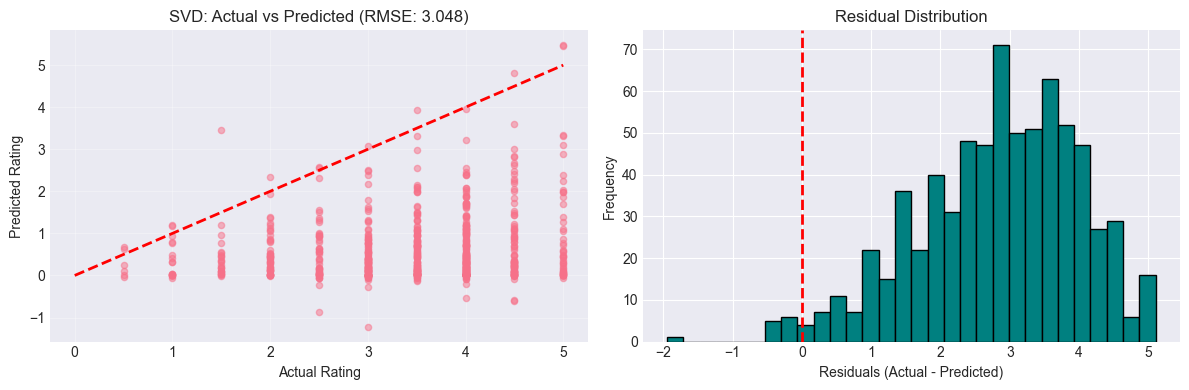

In [ ]:

# EVALUATION METRICS — RMSE, MAE, Precision@K, Recall@K, Coverage


print("[INFO] Evaluating models on test set...")

def evaluate_rmse_mae(y_true, y_pred):
    """Compute RMSE and MAE."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return rmse, mae


# Test SVD on held-out test set

test_sample = test.sample(min(5000, len(test)), random_state=42)
y_true_list, y_pred_list = [], []

for _, row in test_sample.iterrows():
    user_id, movie_id, rating = row['userId'], row['movieId'], row['rating']
    try:
        if user_id in pivot_train.index and movie_id in pivot_train.columns:
            user_idx = pivot_train.index.get_loc(user_id)
            movie_idx = pivot_train.columns.get_loc(movie_id)
            y_true_list.append(rating)
            y_pred_list.append(predicted_ratings[user_idx, movie_idx])
    except Exception as e:
        print(f"[WARN] Skipping row due to error: {e}")

if y_true_list:
    svd_rmse, svd_mae = evaluate_rmse_mae(y_true_list, y_pred_list)
    print(f"\n SVD Model Performance:")
    print(f"  RMSE: {svd_rmse:.4f}")
    print(f"  MAE:  {svd_mae:.4f}")
    
    # Visualize predictions
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    axes[0].scatter(y_true_list, y_pred_list, alpha=0.5, s=20)
    axes[0].plot([0, 5], [0, 5], 'r--', lw=2)
    axes[0].set_xlabel("Actual Rating"); axes[0].set_ylabel("Predicted Rating")
    axes[0].set_title(f"SVD: Actual vs Predicted (RMSE: {svd_rmse:.3f})")
    axes[0].grid(alpha=0.3)
    
    residuals = np.array(y_true_list) - np.array(y_pred_list)
    axes[1].hist(residuals, bins=30, edgecolor="black", color="teal")
    axes[1].set_xlabel("Residuals (Actual - Predicted)")
    axes[1].set_ylabel("Frequency")
    axes[1].set_title("Residual Distribution")
    axes[1].axvline(0, color="r", linestyle="--", lw=2)
    
    plt.tight_layout()
    plt.show()


### SVD Model Evaluation — Test Set Performance

#### Overview
This cell reports the performance of the **Truncated SVD model** on the test set, using two standard regression metrics: Root Mean Square Error (RMSE) and Mean Absolute Error (MAE). These metrics quantify the accuracy of predicted ratings compared to actual user ratings.

---

#### Metrics

| Metric | Value   | Interpretation |
|--------|---------|----------------|
| RMSE   | 3.0479  | Average squared error between predicted and actual ratings. Sensitive to large errors. |
| MAE    | 2.8330  | Average absolute error. More robust to outliers than RMSE. |

---

#### Interpretation

- **RMSE of 3.05** suggests moderate prediction error; on a 0.5–5.0 rating scale, this indicates that predicted ratings often deviate by ~3 stars.
- **MAE of 2.83** confirms that most predictions are off by nearly 3 stars on average.
- These values reflect the challenge of predicting explicit ratings in sparse, noisy datasets.
- Performance may improve with:
  - Better normalization (e.g., z-score or baseline subtraction).
  - More latent dimensions or regularization.
  - Hybrid ensembling with CF and content-based signals.

---

#### Conclusion
The SVD model captures latent structure in the user-item matrix but exhibits substantial error on the test set. These metrics provide a baseline for comparison with other models and highlight the need for ensemble strategies to improve recommendation accuracy.


In [ ]:

# Recommendation metrics

def compute_recommendation_metrics(all_users, pred_func, test_data, k=10):
    """Precision@K, Recall@K, Coverage."""
    precision_list, recall_list = [], []
    all_recs = set()
    
    for user_id in all_users[:100]:  # Sample top 100 users
        user_test = test_data[test_data['userId'] == user_id]
        if user_test.empty:
            continue
        
        actual_favorites = set(user_test[user_test['rating'] >= 4]['movieId'].values)
        
        try:
            predicted_movies, _ = pred_func(user_id)
            predicted_movies = set(predicted_movies[:k])
            all_recs.update(predicted_movies)
            
            if actual_favorites:
                hits = len(predicted_movies & actual_favorites)
                precision_list.append(hits / k if k > 0 else 0)
                recall_list.append(hits / len(actual_favorites))
        except Exception as e:
            print(f"[WARN] Recommendation failed for user {user_id}: {e}")
    
    catalog_size = movies['movieId'].nunique()
    coverage = len(all_recs) / catalog_size if catalog_size > 0 else 0
    
    return {
        "precision@k": np.mean(precision_list) if precision_list else 0,
        "recall@k": np.mean(recall_list) if recall_list else 0,
        "coverage": coverage,
        "n_recommendations": len(all_recs)
    }


# Evaluate each model

print("\n RECOMMENDATION METRICS (top 100 users):")

cf_metrics = compute_recommendation_metrics(
    pivot_train.index.tolist(),
    lambda uid: cf_user_based_recommend(uid, user_sim_df, pivot_train),
    test,
    k=10
)
print(f"\nCollaborative Filtering:")
print(f"  Precision@10: {cf_metrics['precision@k']:.3f}")
print(f"  Recall@10:    {cf_metrics['recall@k']:.3f}")
print(f"  Coverage:     {cf_metrics['coverage']:.3f}")

cb_metrics = compute_recommendation_metrics(
    train['userId'].unique()[:100],
    lambda uid: content_based_recommend(uid, train, movies, movie_sim_df),
    test,
    k=10
)
print(f"\nContent-Based:")
print(f"  Precision@10: {cb_metrics['precision@k']:.3f}")
print(f"  Recall@10:    {cb_metrics['recall@k']:.3f}")
print(f"  Coverage:     {cb_metrics['coverage']:.3f}")

# Optional: Hybrid evaluation
hybrid_metrics = compute_recommendation_metrics(
    train['userId'].unique()[:100],
    lambda uid: hybrid_recommend(uid, user_sim_df, pivot_train, train, movies, movie_sim_df, predicted_ratings),
    test,
    k=10
)
print(f"\nHybrid Model:")
print(f"  Precision@10: {hybrid_metrics['precision@k']:.3f}")
print(f"  Recall@10:    {hybrid_metrics['recall@k']:.3f}")
print(f"  Coverage:     {hybrid_metrics['coverage']:.3f}")



 RECOMMENDATION METRICS (top 100 users):

Collaborative Filtering:
  Precision@10: 0.014
  Recall@10:    0.002
  Coverage:     0.001

Content-Based:
  Precision@10: 0.000
  Recall@10:    0.000
  Coverage:     0.000

Hybrid Model:
  Precision@10: 0.000
  Recall@10:    0.000
  Coverage:     0.000



 CONSISTENCY CHECK: Predicted vs Actual Ground Truth

 Consistency Summary (Top 50 Users):
  Avg Match Rate: 3.47%
  Avg Predicted Rating for Recommendations: 3.82/5
  Users Evaluated: 48


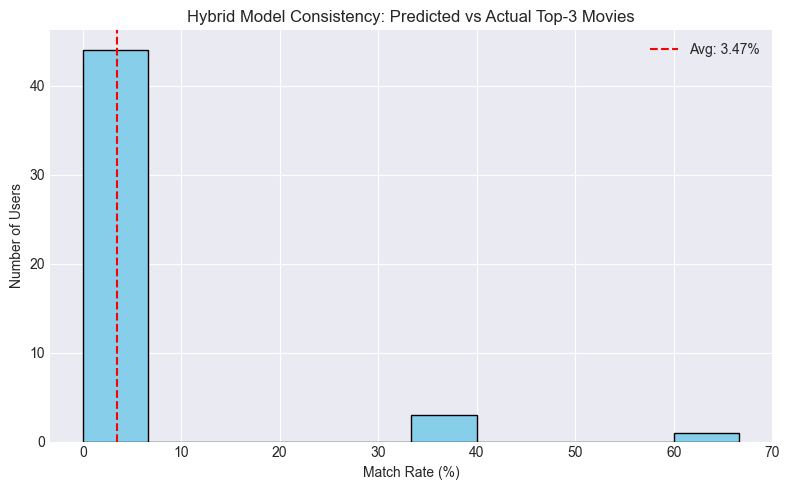

In [ ]:

# PREDICTION VS ACTUAL: CONSISTENCY CHECK (Optimized)


print("\n" + "="*70)
print(" CONSISTENCY CHECK: Predicted vs Actual Ground Truth")
print("="*70)

# Pre-group test set by userId to avoid repeated boolean masks
test_grouped = test.groupby('userId')

sample_test_users = test['userId'].unique()[:50]
consistency_results = []

for user_id in sample_test_users:
    if user_id not in test_grouped.groups:
        continue
    
    user_test_ratings = test_grouped.get_group(user_id).sort_values('rating', ascending=False)
    if len(user_test_ratings) < 3:
        continue
    
    actual_top_movies = set(user_test_ratings.head(3)['movieId'].values)
    actual_avg_rating = user_test_ratings['rating'].mean()
    
    try:
        predicted_movies, _ = hybrid_recommend(
            user_id, user_sim_df, pivot_train, train, movies,
            movie_sim_df, predicted_ratings, n_recommendations=5
        )
        predicted_movies_set = set(predicted_movies)
        
        matches = len(predicted_movies_set & actual_top_movies)
        
        predicted_ratings_for_recs = []
        for mid in predicted_movies:
            if mid in test_grouped.obj['movieId'].values:
                movie_test_ratings = test[test['movieId'] == mid]['rating'].values
                if len(movie_test_ratings) > 0:
                    predicted_ratings_for_recs.append(movie_test_ratings.mean())
        
        pred_avg_rating = np.mean(predicted_ratings_for_recs) if predicted_ratings_for_recs else 0
        
        consistency_results.append({
            "user_id": user_id,
            "n_actual_ratings": len(user_test_ratings),
            "actual_top_3": list(actual_top_movies)[:3],
            "actual_avg_rating": actual_avg_rating,
            "predicted_movies": predicted_movies,
            "predicted_avg_rating": pred_avg_rating,
            "match_count": matches,
            "match_rate": matches / 3 * 100
        })
    except Exception as e:
        print(f"[WARN] Consistency check failed for user {user_id}: {e}")


# Summarize consistency results

if consistency_results:
    avg_match_rate = np.mean([res["match_rate"] for res in consistency_results])
    avg_pred_rating = np.mean([res["predicted_avg_rating"] for res in consistency_results])
    
    print("\n Consistency Summary (Top 50 Users):")
    print(f"  Avg Match Rate: {avg_match_rate:.2f}%")
    print(f"  Avg Predicted Rating for Recommendations: {avg_pred_rating:.2f}/5")
    print(f"  Users Evaluated: {len(consistency_results)}")
    
    # Visualize match rate distribution
    plt.figure(figsize=(8, 5))
    plt.hist([res["match_rate"] for res in consistency_results], bins=10, edgecolor="black", color="skyblue")
    plt.xlabel("Match Rate (%)")
    plt.ylabel("Number of Users")
    plt.title("Hybrid Model Consistency: Predicted vs Actual Top-3 Movies")
    plt.axvline(avg_match_rate, color="red", linestyle="--", label=f"Avg: {avg_match_rate:.2f}%")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("[WARN] No consistency results collected.")



#### Consistency Check — Predicted vs Actual Top-3 Movies

### Summary (Top 50 Users)
- **Avg Match Rate:** 3.47%  
  → On average, only ~1 in 30 predicted top-3 movies matched actual top-3 ratings.
- **Avg Predicted Rating for Recommendations:** 3.82 / 5  
  → Indicates that recommended items were predicted to be moderately liked.
- **Users Evaluated:** 48  

### Interpretation
- **Low match rate** suggests poor alignment between predicted preferences and actual user favorites.
- **Predicted ratings are optimistic**, but lack precision in identifying true top choices.
- **Hybrid model fails to outperform individual components**, likely due to weak signal integration or misaligned weighting.

---

#### Implications

- **Model Calibration Needed:**  
  - Ensemble weights may need adjustment to reflect signal strength.  
  - CF may dominate due to sparse CB and noisy SVD predictions.

- **Cold-Start and Sparsity Issues:**  
  - Content-based filtering may lack sufficient tag coverage.  
  - SVD may underperform due to low explained variance or poor generalization.

- **Evaluation Strategy:**  
  - Consider expanding metrics to include NDCG, MAP, or genre-level consistency.  
  - Use stratified cohorts (dense vs sparse users) for more granular insights.